# Generative models

Showcase the following methods for generating models:
- EM algorithm for mixture of Gaussians,
- Variational Auto Encoder,
- Normalizing flows,
- Generative adversarial models.

### Mixture of Gaussians and EM Algorithm

% EM Algorithm for Mixture of Gaussians

The Expectation-Maximization (EM) algorithm is used to find the maximum likelihood estimates of parameters in models with latent variables. For a Mixture of Gaussians, the model aims to fit a mixture of several Gaussian distributions to the data. The parameters to estimate include the means ($\mu_k$), covariances ($\Sigma_k$), and mixing coefficients $(\pi_k)$ for each Gaussian component in the mixture.

The EM algorithm consists of two main steps iterated until convergence:

1. **Expectation (E) step:**
   Calculate the expected membership probabilities for each data point given the current parameter estimates. This step computes the posterior probability that each data point belongs to each cluster (Gaussian component), based on the current estimates of the parameters. This is given by:

   \begin{equation}
   \gamma(z_{nk}) = \frac{\pi_k \mathcal{N}(x_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_n | \mu_j, \Sigma_j)}
   \end{equation}

   where:
   - $\gamma(z_{nk})$ is the responsibility that component $k$ takes for data point $x_n$.
   - $\mathcal{N}(x_n | \mu_k, \Sigma_k)$ is the probability density of data point $x_n$ under the Gaussian model for component $k$.
   - $K$ is the number of components in the mixture.
   - $n$ indexes over data points.

2. **Maximization (M) step:**
   Update the parameters ($\mu_k$, $\Sigma_k$, $\pi_k$) of each Gaussian component based on the expected memberships computed in the E step. The new parameters are computed as follows:

   \begin{align}
   \mu_k &= \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}) x_n \\
   \Sigma_k &= \frac{1}{N_k} \sum_{n=1}^N \gamma(z_{nk}) (x_n - \mu_k)(x_n - \mu_k)^T \\
   \pi_k &= \frac{N_k}{N}
   \end{align}

   where $N_k = \sum_{n=1}^N \gamma(z_{nk})$ is the effective number of points assigned to cluster $k$, and $N$ is the total number of data points.

The EM algorithm alternates between these E and M steps until the change in the log-likelihood function (or alternatively the change in parameter estimates) falls below a predefined threshold, indicating convergence. The result is a set of parameters that locally maximize the likelihood of the observed data under the mixture model.

First generate the data as a mixture of Gaussians.

/var/folders/c3/8qf_y_jj6393y3l0dl0bb3k80000gp/T/ipykernel_91527/3389397594.py:39: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))


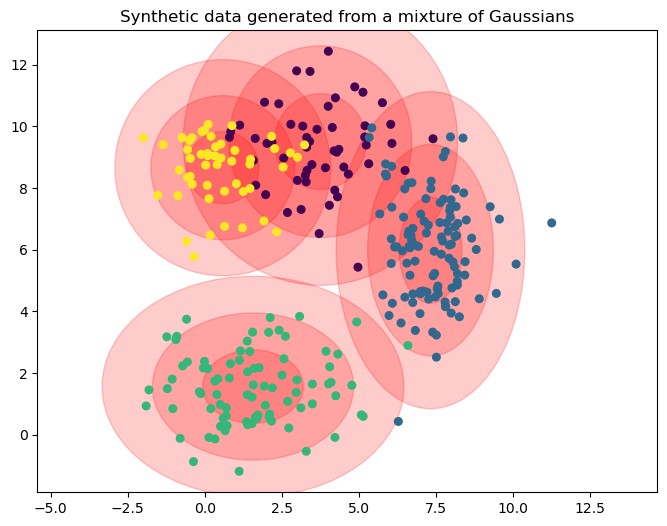

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

# Set parameters
n = 300  # Total number of data points
K = 4    # Number of gaussians

# Define some random parameters for our synthetic gaussians
np.random.seed(42)  # For reproducibility
means = np.random.rand(K, 2) * 10  # Means randomly chosen in [0, 10)
covariances = np.array([np.diag(np.random.rand(2) * 2 + 1) for _ in range(K)])  # Diagonal covariances

# Generate synthetic data
weights = np.random.dirichlet(np.ones(K), size=1).ravel()  # Mixing proportions
data = np.vstack([np.random.multivariate_normal(means[k], covariances[k], size=int(w * n))
                  for k, w in enumerate(weights)])

# True labels (for coloring)
true_labels = np.hstack([k * np.ones(int(w * n), dtype=int) for k, w in enumerate(weights)])

# Function to draw ellipses
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

# Plot initial data
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c=true_labels, s=30, cmap='viridis', zorder=2)
plt.axis('equal')

# Draw true ellipses
for pos, covar in zip(means, covariances):
    draw_ellipse(pos, covar, alpha=0.2, color='red')

plt.title('Synthetic data generated from a mixture of Gaussians')
plt.show()


Implements the steps of the EM algorithm.

/var/folders/c3/8qf_y_jj6393y3l0dl0bb3k80000gp/T/ipykernel_91527/3389397594.py:39: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))


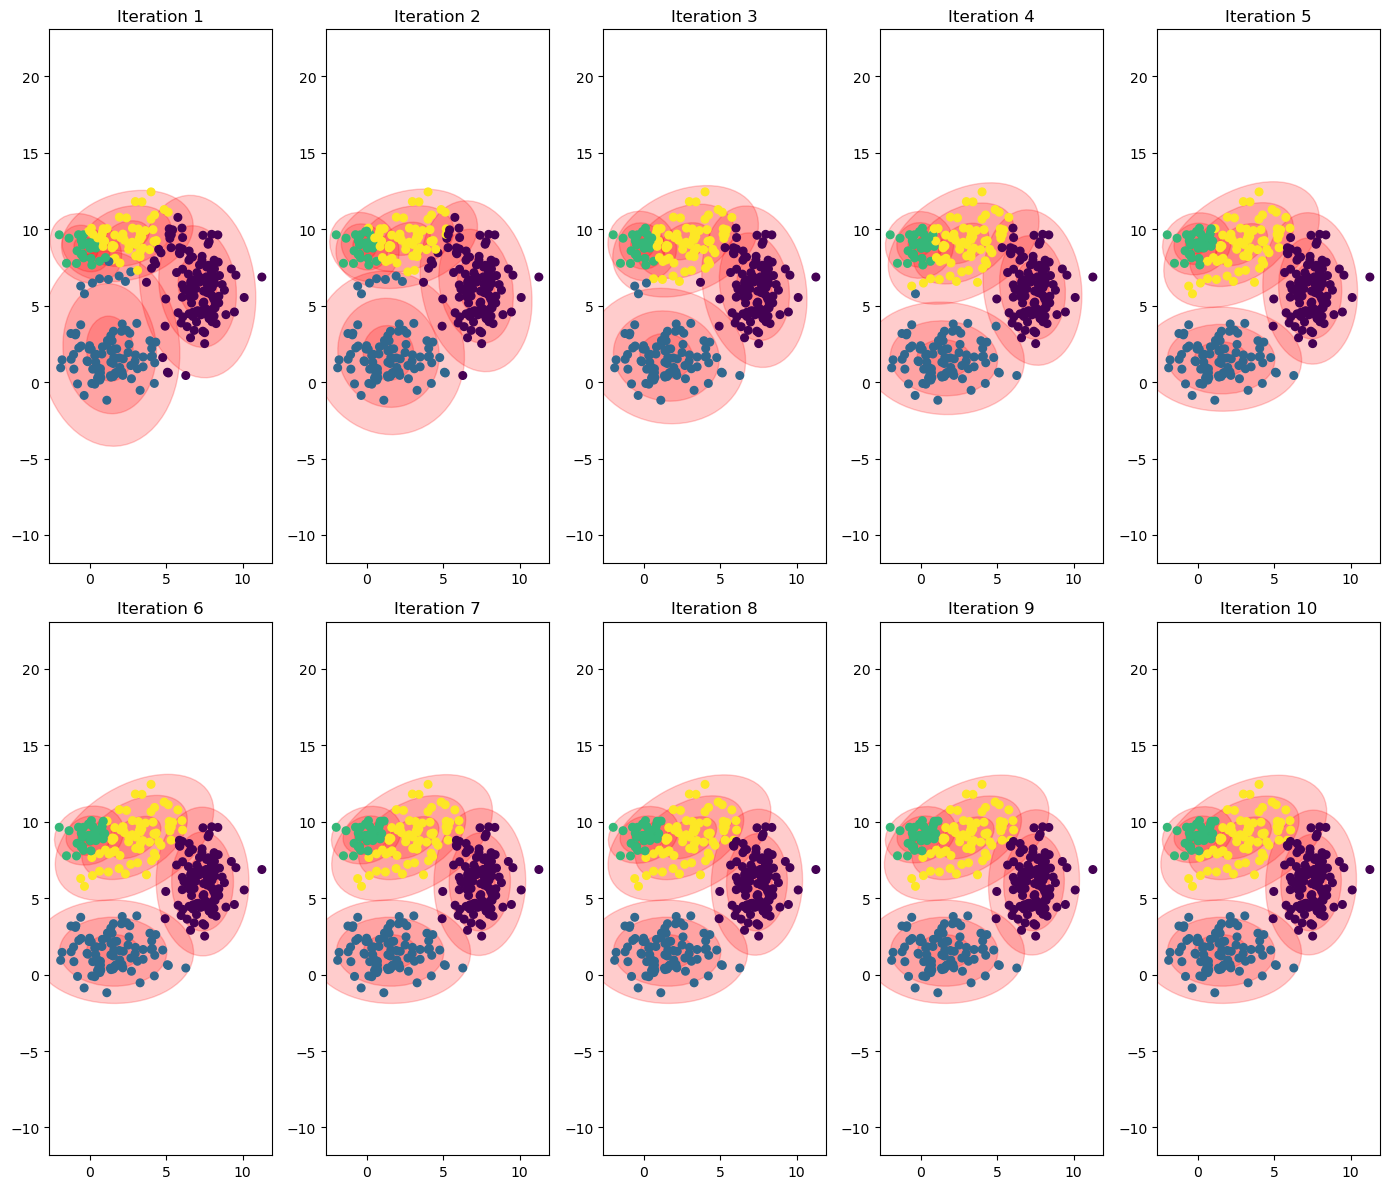

In [2]:
def init_params(data, K):
    """Initialize the parameters for EM algorithm."""
    np.random.seed(42)
    n, d = data.shape
    means = data[np.random.choice(n, K, False), :]
    covariances = np.array([np.eye(d)] * K)
    pis = np.ones(K) / K
    return means, covariances, pis

def e_step(data, means, covariances, pis):
    """E-step: compute responsibilities."""
    n, K = len(data), len(pis)
    gamma = np.zeros((n, K))
    for k in range(K):
        rv = multivariate_normal(means[k], covariances[k])
        gamma[:, k] = pis[k] * rv.pdf(data)
    gamma /= gamma.sum(axis=1, keepdims=True)
    return gamma

def m_step(data, gamma):
    """M-step: update parameters using the current responsibilities."""
    n, K = gamma.shape
    Nk = gamma.sum(axis=0)
    means = np.dot(gamma.T, data) / Nk[:, None]
    covariances = np.zeros((K, data.shape[1], data.shape[1]))
    for k in range(K):
        X_centered = data - means[k]
        covariances[k] = np.dot(gamma[:, k] * X_centered.T, X_centered) / Nk[k]
    pis = Nk / n
    return means, covariances, pis

def run_em(data, K, max_iter=10):
    """Run the EM algorithm for a specified number of iterations."""
    # Initialize parameters
    means, covariances, pis = init_params(data, K)
    
    # Run EM for a certain number of iterations
    plt.figure(figsize=(14, 12))
    for i in range(max_iter):
        # E-step
        gamma = e_step(data, means, covariances, pis)
        # M-step
        means, covariances, pis = m_step(data, gamma)
        
        # Plotting
        plt.subplot(2, (max_iter + 1) // 2, i + 1)
        plt.scatter(data[:, 0], data[:, 1], c=gamma.argmax(axis=1), s=30, cmap='viridis', zorder=2)
        plt.axis('equal')
        for mean, covar in zip(means, covariances):
            draw_ellipse(mean, covar, alpha=0.2, color='red')
        plt.title(f'Iteration {i+1}')
    plt.tight_layout()
    return means, covariances, pis

# Run the EM algorithm and plot the progress
from scipy.stats import multivariate_normal
final_means, final_covariances, final_pis = run_em(data, K)


### Variational Auto-Encoders

A Variational Autoencoder (VAE) is a generative model that learns to encode data to a latent space and then decode from this space back to the data space. The objective of the VAE is defined by the Evidence Lower BOund (ELBO), which the training process seeks to maximize:

\begin{equation}
\mathcal{L}(\theta, \phi; x) = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - \mathbb{KL}(q_\phi(z|x) || p(z))
\end{equation}

Here:
- $x$ is a data sample from the dataset.
- $z$ is a latent space vector.
- $q_\phi(z|x)$ is the encoding distribution mapping data to the latent space, parameterized by $\phi$.
- $p_\theta(x|z)$ is the decoding distribution mapping the latent space back to data space, parameterized by $\theta$.
- $\mathbb{KL}(q_\phi(z|x) || p(z))$ is the Kullback-Leibler divergence between the encoding distribution and a prior distribution $p(z)$, typically assumed to be a standard Gaussian.

The training process involves two main phases:

1. **Encoding (or Recognition) phase:** 
   The input data $x$ is passed through the encoder to produce the parameters (mean and variance) of the encoding distribution $q_\phi(z|x)$. This phase is responsible for compressing the data into the latent space.

2. **Decoding (or Generation) phase:** 
   A sample $z$ from the encoding distribution is passed through the decoder to reconstruct the data, producing $\hat{x}$ which is the reconstruction of $x$. This phase aims to reconstruct the original data from the compressed latent representation.

The loss function for training a VAE is the negative of the ELBO, which can be decomposed into two terms:
- Reconstruction loss ($\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]$): This term encourages the decoded samples to match the original inputs, promoting accurate reconstruction.
- Regularization loss ($\mathbb{KL}(q_\phi(z|x) || p(z))$): This term enforces the latent space to approximate the prior distribution, ensuring a well-structured latent space.

By maximizing the ELBO (or minimizing the negative ELBO), the VAE learns a compact latent representation of the data and a generative process that can produce new data samples similar to those in the training set.

Now define the auto-encoder architectures, with both encoder and decoder.

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, kl_divergence
import numpy as np
import matplotlib.pyplot as plt

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(2, 128)
        self.fc21 = nn.Linear(128, 2)  # Mean output
        self.fc22 = nn.Linear(128, 2)  # Log variance output
        # Decoder
        self.fc3 = nn.Linear(2, 128)
        self.fc4 = nn.Linear(128, 2)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 2))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

Train the auto-encoder minimizing the ELBO functional. 

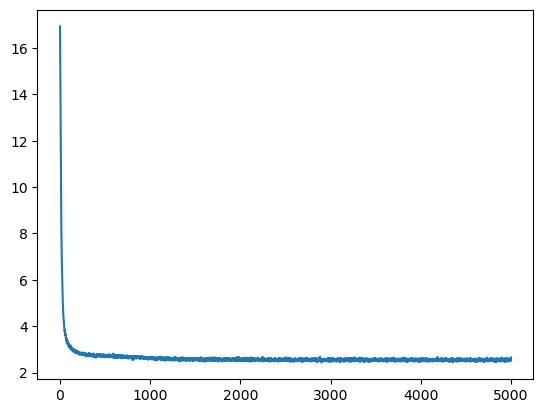

In [65]:
# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x.view(-1, 2), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Generate synthetic data: mixture of Gaussians
def generate_data(n=1000, means=[(0,0), (5,5)], stds=[(1,1), (1,1)]):
    data = []
    for mean, std in zip(means, stds):
        data.append(np.random.normal(loc=mean, scale=std, size=(n, 2)))
    return torch.tensor(np.concatenate(data, axis=0), dtype=torch.float)

# Training parameters
batch_size = 500
epochs = 5000
learning_rate = 1e-3

# Model, optimizer, and data
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
data = generate_data(n=500, means=[(0,0), (4,4)])  # Generate synthetic dataset

# Training loop
loss_list = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for i in range(0, data.size(0), batch_size):
        batch = data[i:i+batch_size]
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    loss_list.append(train_loss / len(data))

# Visualize latent space
def visualize_latent_space(model, data):
    model.eval()
    with torch.no_grad():
        mu, _ = model.encode(data)
        plt.scatter(mu[:, 0], mu[:, 1])
        plt.xlabel('z1')
        plt.ylabel('z2')
        plt.title('Latent space')
        plt.show()
 # display evolution of the loss 
plt.plot(loss_list)

Display the means in latent space.

Text(0.5, 1.0, 'Latent space')

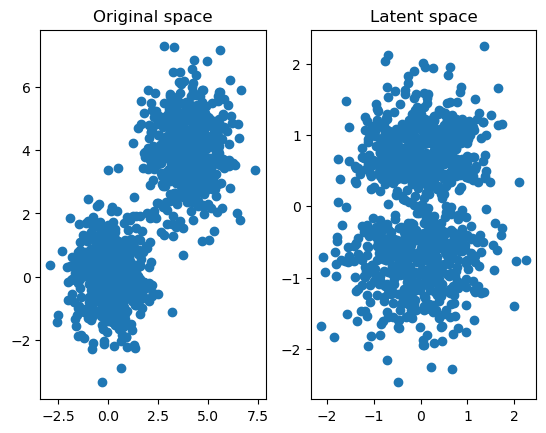

In [123]:
plt.subplot(1,2,1)
plt.scatter(data[:, 0], data[:, 1])
plt.title('Original space')
plt.subplot(1,2,2)
model.eval()
with torch.no_grad():
    mu, std = model.encode(data)
plt.scatter(mu[:, 0], mu[:, 1])
plt.title('Latent space')

Display standard deviation output

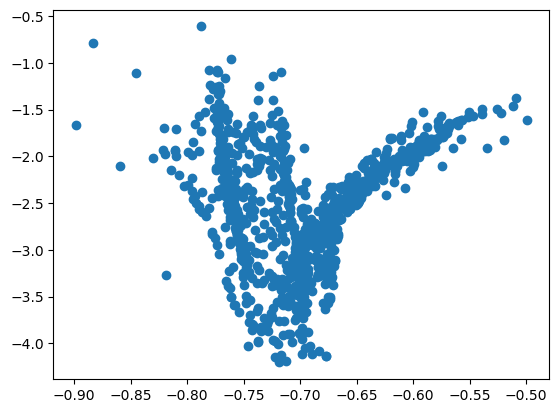

In [67]:
plt.scatter( std[:,0], std[:,1] )

## Normalizing flows

Normalizing flows, such as Real-valued Non-Volume Preserving (Real NVP) models, are designed to learn complex data distributions through a series of invertible transformations. The objective is to transform a simple base distribution (e.g., a standard Gaussian) into a more complex target distribution matching the data. The Real NVP architecture allows for efficient computation of both the forward transformation and its inverse, as well as the determinant of the Jacobian of the transformation, crucial for density estimation. 

The transformations in Real NVP are structured so that they are easy to invert and the Jacobian determinant is easy to compute. This is achieved using affine coupling layers, where the input is split, and only one part is transformed:

\begin{equation}
\text{Let } x = (x_1, x_2) \text{ and let the output } y = (y_1, y_2) \text{ be defined as:}
\end{equation}

\begin{equation}
y_1 = x_1
\end{equation}

\begin{equation}
y_2 = x_2 \odot \exp(s(x_1)) + t(x_1)
\end{equation}

Here, $s$ and $t$ are arbitrary functions from $\mathbb{R}^d \rightarrow \mathbb{R}^d$, and $\odot$ represents element-wise multiplication. Functions $s$ and $t$ are outputs of neural networks and are responsible for the scaling and translation transformations, respectively. The split ensures that the Jacobian matrix is triangular, simplifying the computation of its determinant.

The training objective is to maximize the likelihood of the observed data under the model, which is equivalent to minimizing the Negative Log-Likelihood (NLL):

\begin{equation}
\min -\mathbb{E}_{x \sim p_{\text{data}}(x)}[\log p_{\text{model}}(x)]
\end{equation}

Here, $p_{\text{model}}(x)$ is the model's estimated probability density of the data, computed using the change of variables formula:

\begin{equation}
\log p_{\text{model}}(x) = \log p_{\text{base}}(f^{-1}(x)) + \log |\det J_f^{-1}(x)|
\end{equation}

Where:
- $f^{-1}$ is the inverse of the flow transformation (mapping data space back to base distribution space).
- $p_{\text{base}}$ is the base distribution density (e.g., standard Gaussian).
- $J_f^{-1}$ is the Jacobian of $f^{-1}$, and $|\det J_f^{-1}|$ is its absolute determinant.

The training involves using backpropagation through the layers and the transformations to update the parameters of the functions $s$ and $t$ to increase the likelihood of the data under the transformed distribution.


We now define the flow model as a sequence of real-valued non-volume preserving (real NVP) layers.

In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions import Normal, MultivariateNormal

# Affine Coupling Layer
class AffineCouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim = 16):
        super().__init__()
        self.input_dim = input_dim
        assert input_dim % 2 == 0, "Input dimension must be even for splitting"
        self.mid_dim = input_dim // 2

        # Define the neural network to be applied to half of the dimensions
        self.net = nn.Sequential(
            nn.Linear(self.mid_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.mid_dim * 2)  # Output for both scale and translation
        )

    def forward(self, x):
        # Split input in two equal parts
        x1, x2 = x[:, :self.mid_dim], x[:, self.mid_dim:]
        # Apply transformation to second half
        st = self.net(x1)
        s, t = st[:, :self.mid_dim], st[:, self.mid_dim:]
        y2 = x2 * torch.exp(s) + t
        # Concatenate the unmodified part with the transformed part
        y = torch.cat((x1, y2), dim=1)
        # Compute log determinant of Jacobian
        log_det_jacobian = s.sum(dim=1)
        return y, log_det_jacobian

    def inverse(self, y):
        # Split input in two equal parts
        y1, y2 = y[:, :self.mid_dim], y[:, self.mid_dim:]
        # Apply inverse transformation to second half
        st = self.net(y1)
        s, t = st[:, :self.mid_dim], st[:, self.mid_dim:]
        x2 = (y2 - t) * torch.exp(-s)
        # Concatenate the unmodified part with the transformed part
        x = torch.cat((y1, x2), dim=1)
        return x

# Define the Real NVP Model
class RealNVP(nn.Module):
    def __init__(self, input_dim, num_flows, hidden_dim = 16):
        super().__init__()
        assert input_dim % 2 == 0, "Input dimension must be even for RealNVP"
        self.flows = nn.ModuleList([AffineCouplingLayer(input_dim, hidden_dim) for _ in range(num_flows)])

    def forward(self, x):
        log_det_jacobians = torch.zeros(x.size(0), device=x.device)
        for flow in self.flows:
            x, log_det_jacobian = flow(x)
            log_det_jacobians += log_det_jacobian
        return x, log_det_jacobians

    def inverse(self, y):
        for flow in reversed(self.flows):
            y = flow.inverse(y)
        return y


Do the training.

<function matplotlib.pyplot.show(close=None, block=None)>

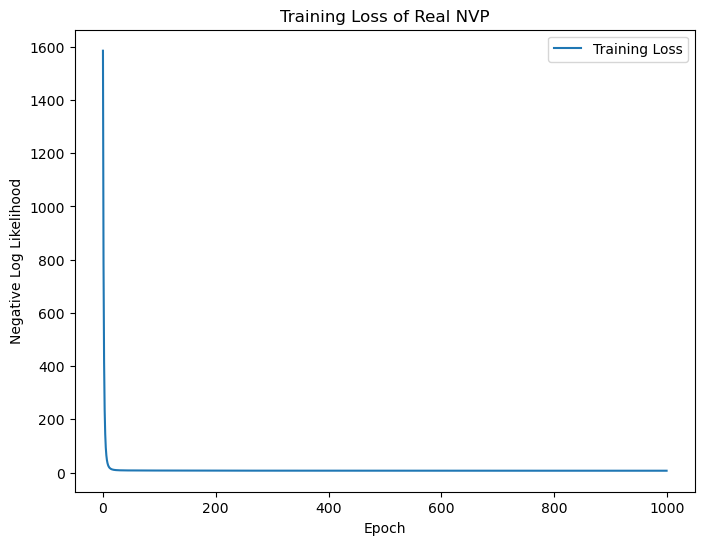

In [104]:
# Parameters for the data and the model
input_dim = 2
num_flows = 8
hidden_dim = 16
num_samples = 500
means = [(0, 0), (4, 4)]

# Generate the data
data = generate_data(num_samples, means)

# Initialize the model and the optimizer
rnvp = RealNVP(input_dim, num_flows)
optimizer = optim.Adam(rnvp.parameters(), lr=0.001)

# Base distribution
base_distribution = MultivariateNormal(torch.zeros(input_dim), torch.eye(input_dim))

# Training loop
nepochs = 1000
losses = []
for epoch in range(nepochs):
    rnvp.train()
    optimizer.zero_grad()
    z, log_det_jacobians = rnvp(data)
    log_prob_z = base_distribution.log_prob(z)
    loss = -torch.mean(log_prob_z + log_det_jacobians)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Plotting the training losses
plt.figure(figsize=[8, 6])
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log Likelihood')
plt.title('Training Loss of Real NVP')
plt.legend()
plt.show

Display the evolution of the trained flow.

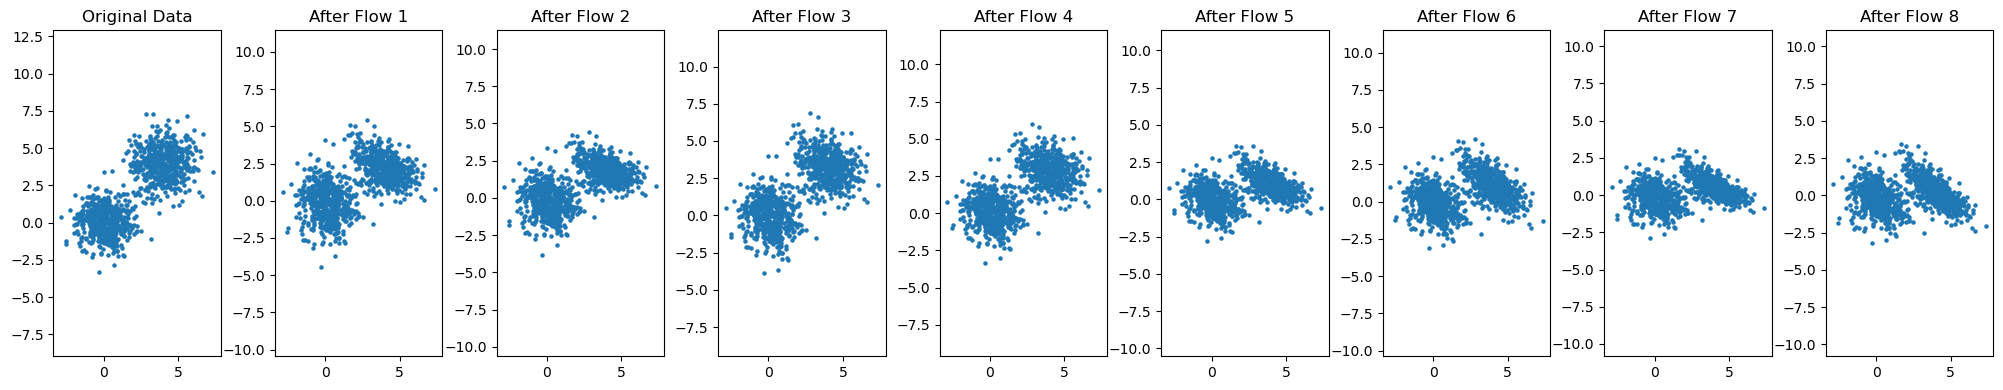

In [105]:
import matplotlib.pyplot as plt

# Function to plot data transformation through Real NVP flows
def plot_flow_transformations(model, data, num_flows):
    fig, axes = plt.subplots(1, num_flows + 1, figsize=(20, 4))
    z = data.detach().cpu().numpy()

    # Original data
    axes[0].scatter(z[:, 0], z[:, 1], s=5)
    axes[0].set_title('Original Data')
    axes[0].axis('equal')

    # Data after passing through each flow
    with torch.no_grad():  # No need to track these operations
        for i in range(num_flows):
            # Apply ith flow
            data, _ = model.flows[i](data)
            z = data.detach().cpu().numpy()
            axes[i + 1].scatter(z[:, 0], z[:, 1], s=5)
            axes[i + 1].set_title(f'After Flow {i + 1}')
            axes[i + 1].axis('equal')

    plt.tight_layout()
    plt.show()

# Now call the function with the trained model and data
plot_flow_transformations(rnvp, data, num_flows)


### Generative Adversarial Networks (GAN)

The objective of a Generative Adversarial Network (GAN) is to train a Generator (G) and a Discriminator (D) in a competitive setting where both improve each other. The training process involves solving a min-max problem represented by the following value function:

\begin{equation}
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]
\end{equation}

Here:
- $x$ is a real data sample from the data distribution $p_{\text{data}}$.
- $z$ is a noise sample from some predefined noise distribution $p_z$.
- $G(z)$ is the output of the generator given noise $z$.
- $D(x)$ is the discriminator's estimate of the probability that real data $x$ is authentic.
- $D(G(z))$ is the discriminator's estimate of the probability that a fake instance $G(z)$ is real.

The training alternates between two main phases:

1. **Discriminator Training (Maximizing phase):** 
   Optimize $D$ to correctly classify real and fake data by maximizing:

   \begin{equation}
   \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]
   \end{equation}

   This encourages the discriminator to assign high probability to real data and low probability to fake data generated by $G$.

2. **Generator Training (Minimizing phase):**
   Optimize $G$ to fool the discriminator by minimizing:

   \begin{equation}
   \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]
   \end{equation}

   This can be equivalently framed as maximizing $\mathbb{E}_{z \sim p_z(z)}[\log D(G(z))]$ to encourage $G$ to produce data that $D$ will classify as real. The generator aims to improve the quality of the generated samples to be as real as possible, deceiving the discriminator.

The process leads to a dynamic equilibrium where the generator produces indistinguishable data from real data, and the discriminator becomes a perfect classifier, unable to distinguish real data from fake.

Define the generator and the discriminator. 

In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

hidden_dim = 32

# Generator model
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, output_dim),
        )
    
    def forward(self, z):
        return self.net(z)

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

Do the training.

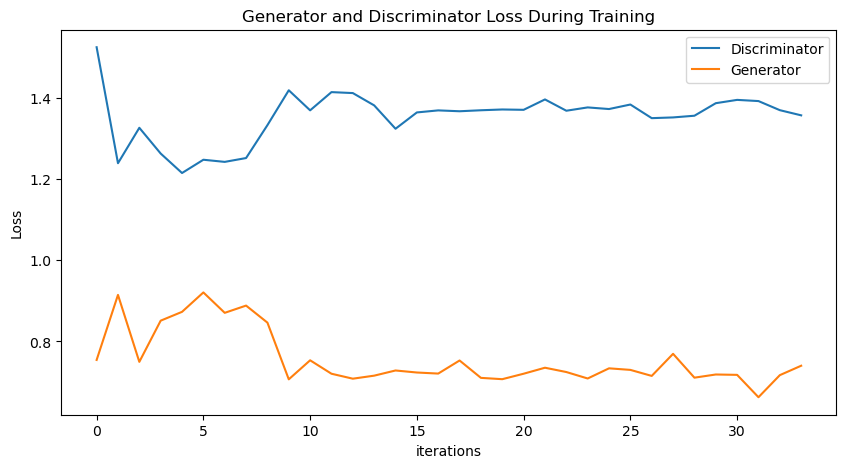

In [121]:
# GAN parameters
z_dim = 4
data_dim = 2
num_samples = 500
means = [(0, 0), (4, 4)]
lr = 0.001
epochs = 10000
batch_size = 500

# Initialize GAN components
generator = Generator(z_dim, data_dim)
discriminator = Discriminator(data_dim)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
criterion = nn.BCELoss()

# Generate real data
real_data = generate_data(num_samples, means).detach()

# Training loop
d_losses, g_losses = [], []
for epoch in range(epochs):
    # Train Discriminator
    for it in range(5):
        discriminator.zero_grad()
        # Real data
        real_labels = torch.ones(batch_size, 1)
        indices = torch.randint(0, real_data.size(0), (batch_size,))
        d_real_data = real_data[indices]
        d_real_decision = discriminator(d_real_data)
        d_real_loss = criterion(d_real_decision, real_labels)
        # Fake data
        z = torch.randn(batch_size, z_dim)
        d_fake_data = generator(z).detach()  # Detach to avoid training generator on these labels
        fake_labels = torch.zeros(batch_size, 1)
        d_fake_decision = discriminator(d_fake_data)
        d_fake_loss = criterion(d_fake_decision, fake_labels)
        # Backprop and optimize
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()

    # Train Generator
    generator.zero_grad()
    z = torch.randn(batch_size, z_dim)
    g_fake_data = generator(z)
    g_decision = discriminator(g_fake_data)
    g_loss = criterion(g_decision, real_labels)  # Train to fool the discriminator
    g_loss.backward()
    g_optimizer.step()

    if epoch % 300 == 0:  # Adjust print frequency as needed
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

# Plotting the loss evolution
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(d_losses,label="Discriminator")
plt.plot(g_losses,label="Generator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


Visualize the generated data generation.

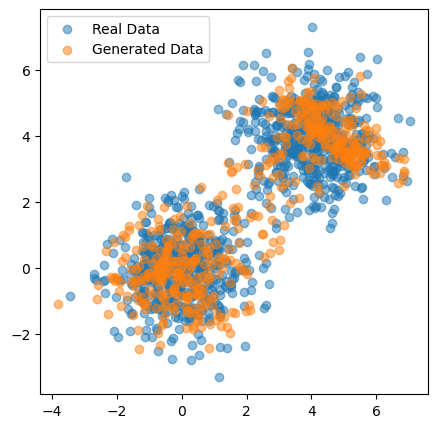

In [122]:
z = torch.randn(num_samples, z_dim)
with torch.no_grad():
    generated_data = generator(z)
plt.figure(figsize=(5,5))
plt.scatter(real_data[:, 0], real_data[:, 1], alpha=0.5, label='Real Data')
plt.scatter(generated_data[:, 0], generated_data[:, 1], alpha=0.5, label='Generated Data')
plt.legend()
plt.show()